# CIS519 Project - Cassava Leaf Image Classification


## Run All Hyper Param

Warning: run all may lose data. Be cautious

In [1]:
redo_data_clean = False
need_retrain_vit = True
need_retrain_res = False
need_clean = False

## Setup

In [20]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

import time
from datetime import datetime
import os
import io
import boto3
from io import BytesIO
import sagemaker
from sagemaker import get_execution_role

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
import torchvision as tv
import torchvision.transforms as T
import torchvision.models as M
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset, random_split
from PIL import Image
import random
from tqdm import tqdm

from torch.cuda.amp import autocast, GradScaler
from datetime import datetime
import pytz

ModuleNotFoundError: No module named 'timm'

In [26]:
%%time
# Set the timezone to Pacific Time
pt = pytz.timezone('America/Los_Angeles')

role = get_execution_role()
print(role)

region = boto3.Session().region_name
sess = sagemaker.Session()

arn:aws:iam::968333200412:role/SageMakerExecutionRole
CPU times: user 77.5 ms, sys: 2.61 ms, total: 80.1 ms
Wall time: 244 ms


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### S3 connection

In [5]:
s3_client = boto3.client('s3')

# List all the buckets
response = s3_client.list_buckets()

# Print the name of each bucket
for bucket in response['Buckets']:
    print(bucket['Name'])
    bucket_name = bucket['Name']

# List all the folders (prefixes) inside the bucket
response = s3_client.list_objects_v2(Bucket=bucket_name, Delimiter='/')

# Print the name of each folder
for content in response.get('CommonPrefixes', []):
    print(content.get('Prefix'))

519bucket
dataset-backup/
dataset-latest/
dataset/


In [6]:
file_path = 'dataset/train.csv'
train_csv_obj = s3_client.get_object(Bucket=bucket_name, Key=file_path)
train_df =pd.read_csv(io.BytesIO(train_csv_obj['Body'].read()))
train_df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [7]:
#count the total number of images 
csv_image_count = train_df['image_id'].count()
display(csv_image_count)

#check the file amount inside train_images folder
folder_path = 'dataset/train_images'

def count_files_in_s3_folder(bucket, prefix):
    paginator = s3_client.get_paginator('list_objects_v2')
    count = 0

    for page in paginator.paginate(Bucket=bucket, Prefix=prefix):
        for obj in page.get('Contents', []):
            if obj['Key'] != prefix:
                count += 1
                
    return count

number_of_files = count_files_in_s3_folder(bucket_name, folder_path)
print(f'There are {number_of_files} files in the folder {folder_path}.')


#check if they are the same
if csv_image_count == number_of_files:
    #show a green light symbol
    display("✅, all images are uploaded.")
else:
    #show a red light symbol
    display("❌, partial uploaded, missing images.")

21397

There are 9729 files in the folder dataset/train_images.


'❌, partial uploaded, missing images.'

### Data clean

**Since the upload speed for S3 would decrease like gradient, we are not able to obtain all train images. Hence here we do a data pre cleaning**


In [8]:
if need_clean:
    new_train_df = train_df.copy()
    for index, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
        file_path = 'dataset/train_images/' + row['image_id']
        try:
            s3_client.head_object(Bucket=bucket_name, Key=file_path)
        except:
            new_train_df = new_train_df.drop(index)

    new_count = new_train_df['image_id'].count()
    display(new_count)
    new_train_df.head()
    
    clean_train_df = new_train_df.copy()
    #add time step to the file name
    clean_train_df.to_csv('clean_train_df_{}.csv'.format(time.time()), index=False)
    # show the label distribution in train
    clean_train_df['label'].value_counts().plot(kind='bar')

## EDA

In [9]:
read_file_from_s3 = lambda file_path: s3_client.get_object(Bucket=bucket_name, Key=file_path)['Body']

pd.read_csv(read_file_from_s3('dataset/train.csv'))

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


<AxesSubplot:>

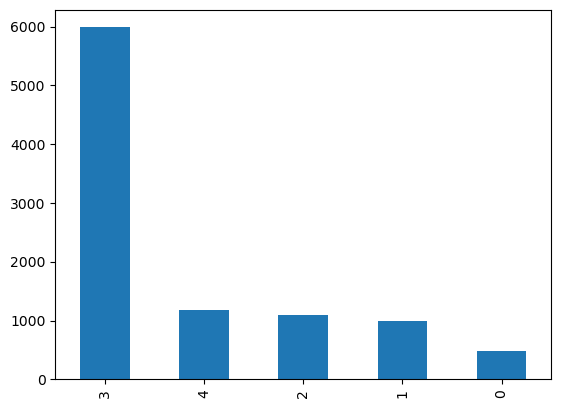

In [10]:
# Print labels and category encodings
path_prefix = 'dataset/'

# Load data
train = pd.read_csv('clean_train_df.csv')
test = pd.read_csv(read_file_from_s3('dataset/sample_submission.csv'))
label_map = pd.read_json(read_file_from_s3('dataset/label_num_to_disease_map.json'), orient='index')

# Print labels and category encodings
display(train.head())
display(test.head())
display(label_map)

# show the label distribution in train
train['label'].value_counts().plot(kind='bar')

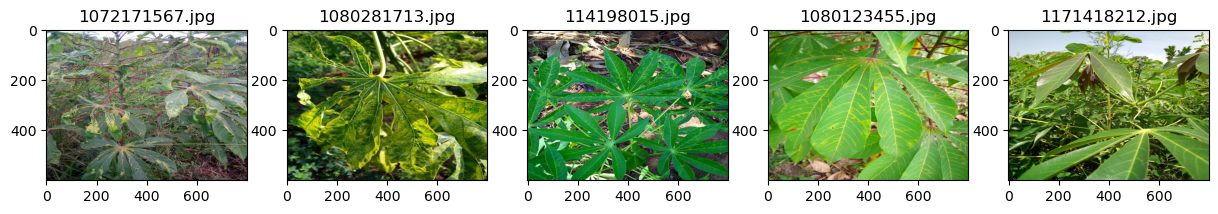

In [11]:
# Visualize raw images
image_dir = path_prefix + 'train_images/'

s3 = boto3.client('s3')
s3_objects = s3.list_objects_v2(Bucket=bucket_name, Prefix=image_dir)['Contents']
image_files = [obj['Key'] for obj in s3_objects]
num_images = 5
sample_images = random.sample(image_files, num_images)
fig, axs = plt.subplots(1, num_images, figsize=(15, 5))
for i, image_file in enumerate(sample_images):
    image_bytes = read_file_from_s3(image_file)
    image = Image.open(image_bytes)
    axs[i].imshow(image)
    image_file_short = image_file.replace(image_dir, '')
    axs[i].set_title(image_file_short)
plt.show()

### DataSet

In [12]:
# Define basic transformation and augmentation
transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

class CassavaDataset(Dataset):
    def __init__(self, csv_path, s3_prefix, transform=None):
        self.data = pd.read_csv(csv_path)
        self.s3_prefix = s3_prefix
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        row = self.data.iloc[index]
        image_path = f"{self.s3_prefix}/{row['image_id']}"
        #now doing good thing
        image_bytes = read_file_from_s3(image_path)
        image = Image.open(image_bytes).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        label = row['label']
        return image, label
        
train_data_path = 'clean_train_df.csv'
s3_prefix = 'dataset/train_images'
dataset = CassavaDataset(train_data_path, s3_prefix, transform=transform)

## 1. Baseline

### 1.1.1 Implementation (Ruichen)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


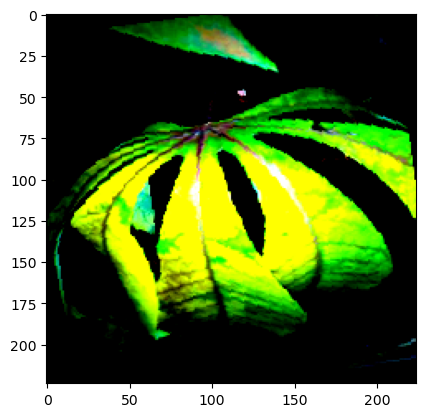

In [13]:
# Visualize transformed image
img_id = train.sample(1)['image_id'].values[0]
sample_image_path = path_prefix + 'train_images/'+ img_id
sample_image = Image.open(read_file_from_s3(sample_image_path))
transformed_image = transform(sample_image)

plt.imshow(transformed_image.permute(1, 2, 0))
plt.show()

In [14]:
# Train test split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Load data
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [21]:
print(torchvision.models.resnet.__all__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

['ResNet', 'ResNet18_Weights', 'ResNet34_Weights', 'ResNet50_Weights', 'ResNet101_Weights', 'ResNet152_Weights', 'ResNeXt50_32X4D_Weights', 'ResNeXt101_32X8D_Weights', 'ResNeXt101_64X4D_Weights', 'Wide_ResNet50_2_Weights', 'Wide_ResNet101_2_Weights', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'resnext50_32x4d', 'resnext101_32x8d', 'resnext101_64x4d', 'wide_resnet50_2', 'wide_resnet101_2']
cuda


In [22]:
if need_retrain_res:
    # Get the current time in Pacific Time
    current_time = datetime.now(pt)
    # Define baseline model
    resnet = M.resnet18(pretrained=True)
    num_classes = 5
    num_ftrs = resnet.fc.in_features
    resnet.fc = nn.Linear(num_ftrs, num_classes)
    resnet.to(device)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(resnet.parameters(), lr=0.001, momentum=0.9)

    # Initialize GradScaler
    scaler = GradScaler()

    # Train baseline model (or more accurately, fine-tune the pre-trained model to apply on our specific dataset)
    num_epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in tqdm(enumerate(train_loader), total = len(train_loader)):
            inputs = inputs.to(device) # Moved input data to the GPU
            labels = labels.to(device) # Moved target labels to the GPU

            optimizer.zero_grad()

            # Use autocast to perform automatic mixed precision training
            with autocast():
                outputs = resnet(inputs)
                loss = criterion(outputs, labels)

            # Scales the loss to avoid underflow or overflow
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
 41%|████      | 100/244 [05:20<07:25,  3.09s/it]

[1,   100] loss: 0.959


 82%|████████▏ | 200/244 [10:31<02:18,  3.14s/it]

[1,   200] loss: 0.714


  0%|          | 1/244 [00:03<14:48,  3.66s/it]


KeyboardInterrupt: 

In [ ]:
timestamp = current_time.strftime('%H:%M')
# Print the current time
print("Current Pacific Time:", timestamp)

model_path = f"models/resnet18-{timestamp}.pth"
torch.save(resnet.state_dict(), model_path)

Now Model is saved under models/ folder. We can load the model and test any time

### 1.2 Evalutation (Alan)

Test on test_loader, and evaluate the model performance:
- Use a table to record accuracy, precision, recall, F1 score
- Draw confusion matrix, precision-recall curve
- Draw AUC-ROC figure

In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import torch.nn.functional as F
import torch
import torchvision.models as models
import torch.nn as nn

'''
state_dict = torch.load("models/resnet18-20:03.pth")
print(state_dict.keys())

model = models.resnet18()
print(model.state_dict().keys())
'''

resnet = models.resnet18(pretrained=False)
num_classes = 5
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, num_classes)

resnet.load_state_dict(torch.load("models/resnet18-20:03.pth"))
resnet.eval()

if torch.cuda.is_available(): resnet.cuda()
# Create empty lists for true labels and predicted labels
true_labels = []
pred_labels = []
probs_labels = []
# Iterate over test dataset and make predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = resnet(inputs)
        preds = F.softmax(outputs, dim=1).argmax(dim=1)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        probs_labels.extend(probs)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

              precision    recall  f1-score   support

           0       0.72      0.89      0.79        87
           1       0.94      0.85      0.90       191
           2       0.87      0.89      0.88       218
           3       0.99      0.96      0.97      1180
           4       0.80      0.90      0.85       270

    accuracy                           0.93      1946
   macro avg       0.86      0.90      0.88      1946
weighted avg       0.93      0.93      0.93      1946

Accuracy: 0.9281
Precision: 0.9340
Recall: 0.9281
F1 score: 0.9298
Confusion matrix:
[[  77    1    1    0    8]
 [  10  163    3    3   12]
 [   2    0  194    4   18]
 [   3    6   20 1129   22]
 [  15    3    6    3  243]]
probs labels shape: 1946
Class 0: AUC = 0.992
Class 1: AUC = 0.995
Class 2: AUC = 0.986
Class 3: AUC = 0.996
Class 4: AUC = 0.984
Micro-averaged AUC = 0.991


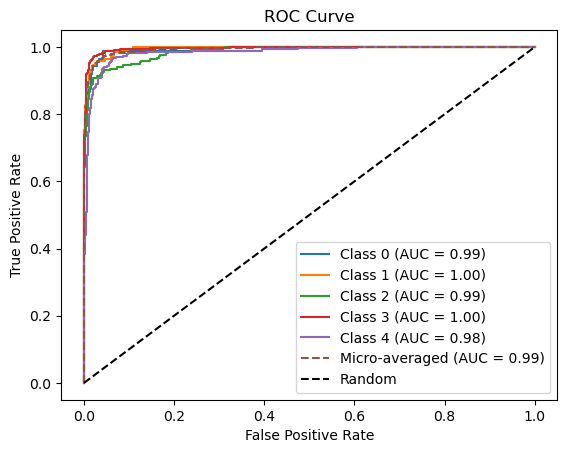

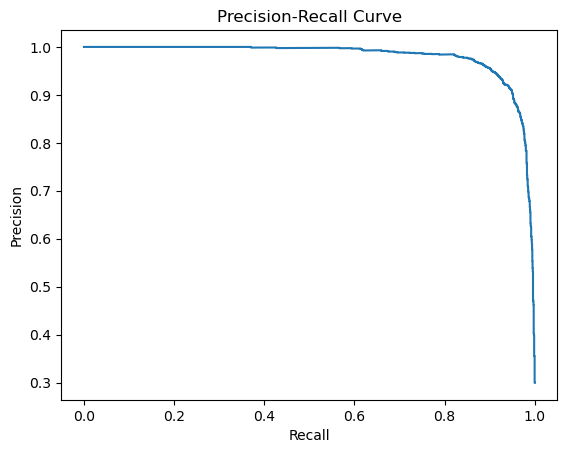

PR_AUC is  0.9795023646853706


'\nprecision, recall, fscore, support = precision_recall_fscore_support(true_labels, pred_labels)\n# Print the results for each class\nfor i in range(num_classes):\n    print(f"Class {i}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1-score={fscore[i]:.3f}")\n# Plot the precision-recall curve\nplt.plot(recall, precision)\nplt.xlabel(\'Recall\')\nplt.ylabel(\'Precision\')\nplt.title(\'Precision-Recall Curve for baseline resnet-18\')\nplt.show()\n\nauc_roc = roc_auc_score(true_labels, pred_labels, multi_class=\'ova\')\nprint(f"auc_roc: {auc_roc:.4f}")\n'

In [92]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

print(classification_report(true_labels, pred_labels))

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
print(f"Confusion matrix:\n{conf_matrix}")

# Compute probabilities for each class
'''
moved above, this hasn't been deleted yet, del if above works
with torch.no_grad():
    probs = F.softmax(resnet(inputs), dim=1).cpu().numpy()
'''
probs_labels = np.array(probs_labels)

print("probs labels shape:", len(probs_labels))

# Compute ROC-AUC scores for each class
auc_scores = []
for i in range(num_classes):
    true_labels_i = (np.array(true_labels) == i).astype(int)
    probs_i = probs_labels[:, i]
    auc_i = roc_auc_score(true_labels_i, probs_i)
    auc_scores.append(auc_i)
    print(f"Class {i}: AUC = {auc_i:.3f}")

# Compute micro-averaged ROC-AUC score
auc_micro = roc_auc_score(np.eye(num_classes)[true_labels], probs_labels, multi_class="ovr")
print(f"Micro-averaged AUC = {auc_micro:.3f}")

# Plot ROC curves for each class
fpr = dict()
tpr = dict()
for i in range(num_classes):
    true_labels_i = (np.array(true_labels) == i).astype(int)
    probs_i = probs_labels[:, i]
    fpr[i], tpr[i], _ = roc_curve(true_labels_i, probs_i)
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {auc_scores[i]:.2f})")

# Plot micro-averaged ROC curve
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[true_labels].ravel(), probs_labels.ravel())
plt.plot(fpr_micro, tpr_micro, label=f"Micro-averaged (AUC = {auc_micro:.2f})", linestyle="--")

# Plot random classifier curve
plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#precision-recall
#first binarize the labels
bin_labels = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])
precision, recall, thresholds = precision_recall_curve(bin_labels.ravel(), probs_labels.ravel())
pr_auc = auc(recall, precision)
#precision, recall, thresholds = precision_recall_curve(true_labels, pred_labels)
plt.plot(recall, precision, label = {pr_auc})
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
print("PR_AUC is ", pr_auc)




'''
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label="class {} (AUC = {:.2f})".format(i, pr_auc[i]))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()
'''
'''
precision, recall, fscore, support = precision_recall_fscore_support(true_labels, pred_labels)
# Print the results for each class
for i in range(num_classes):
    print(f"Class {i}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1-score={fscore[i]:.3f}")
# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for baseline resnet-18')
plt.show()

auc_roc = roc_auc_score(true_labels, pred_labels, multi_class='ova')
print(f"auc_roc: {auc_roc:.4f}")
'''

## 2. Fine-tuning Kaggle Solution

### 2.1 Implementation (Qihang)

#### Base VIT Model

basic data load, seed and transform adpot from [here](https://www.kaggle.com/code/abhinand05/vision-transformer-vit-tutorial-baseline/notebook#notebook-container)


In [15]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False


seed_everything(1001)

import torchvision.transforms as transforms

IMG_SIZE = 224

transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

#### VIT Model

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [17]:
print(torch.__version__)

1.13.1


In [21]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 kB 48.2 MB/s eta 0:00:00


In [24]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
import timm

class VitClassifier(nn.Module):
    def __init__(self, model_name="vit_base_patch16_224", n_classes=5, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, n_classes)
        
        self.best_val_loss = float('inf')  # initialize best validation loss to infinity
        self.early_stopping_rounds = 3  # number of epochs to wait before early stopping
        self.epochs_without_improvement = 0  # number of epochs without improvement
        
        self.scaler = GradScaler()  # initialize GradScaler
    
    def forward(self, x):
        x = self.model(x)
        return x
    
    def evaluate(self, loader, criterion, device):
        self.model.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            for data, target in loader:
                data, target = data.to(device), target.to(device)
                output = self.model(data)
                val_loss += criterion(output, target).item()
                val_acc += (output.argmax(1) == target).sum().item()

        val_loss /= len(loader)
        val_acc /= len(loader.dataset)
        return val_loss, val_acc
    
    def train_one(self, loader, optimizer, criterion, device, val_loader=None):
        self.model.train()
        train_loss = 0
        train_acc = 0
        pbar = tqdm(enumerate(loader), total=len(loader))
        for step, batch in pbar:
            optimizer.zero_grad()
            data, target = batch
            data, target = data.to(device), target.to(device)

            with autocast():
                output = self.model(data)
                loss = criterion(output, target)

            self.scaler.scale(loss).backward()
            self.scaler.step(optimizer)
            self.scaler.update()

            train_loss += loss.item()
            train_acc += (output.argmax(1) == target).sum().item()

        train_loss /= len(loader)
        train_acc /= len(loader.dataset)

        if val_loader is not None:
            val_loss, val_acc = self.evaluate(val_loader, criterion, device)
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

        if self.epochs_without_improvement >= self.early_stopping_rounds:
            print(f'Validation loss has not improved in {self.early_stopping_rounds} epochs. Early stopping...')
            return train_loss, train_acc, True
        else:
            return train_loss, train_acc, False


In [27]:
model = VitClassifier(model_name="vit_base_patch16_224", n_classes=5, pretrained=True)

torch.cuda.empty_cache()

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-05)

criterion = nn.CrossEntropyLoss()

batch_size_vit = 16
num_workers = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size_vit, shuffle=True, num_workers = num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size_vit, shuffle=True, num_workers = num_workers)


def train(model, optimizer, criterion, train_loader, val_loader, device, epochs=4):
    current_time = datetime.now(pt)
    timestamp = current_time.strftime('%m/%d %H:%M')
    print(f"total train epochs: {epochs}")
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    start_time = time.time()
    for epoch in range(epochs):
        print(f"Epoch: {epoch + 1}  / {epochs}")
        train_loss, train_acc, early_stopping = model.train_one(train_loader, optimizer, criterion, device)
        val_loss, val_acc = model.evaluate(val_loader, criterion, device)
        print(f"Epoch: {epoch + 1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        torch.save(model.state_dict(), f"models/vit_{timestamp}_epoch_{epoch}.pth")
    time_elapsed = time.time() - start_time
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    return train_losses, train_accs, val_losses, val_accs
if need_retrain_vit:
    train_losses, train_accs, val_losses, val_accs = train(model, optimizer, criterion, train_loader, test_loader, device, epochs=10)
    current_time = datetime.now(pt)
    timestamp = current_time.strftime('%H:%M')

total train epochs: 10
Epoch: 1  / 10


100%|██████████| 487/487 [06:57<00:00,  1.17it/s]


Epoch: 1 | Train Loss: 0.6190 | Train Acc: 0.7876 | Val Loss: 0.4105 | Val Acc: 0.8638
Epoch: 2  / 10


100%|██████████| 487/487 [05:47<00:00,  1.40it/s]


Epoch: 2 | Train Loss: 0.3970 | Train Acc: 0.8680 | Val Loss: 0.3935 | Val Acc: 0.8710
Epoch: 3  / 10


100%|██████████| 487/487 [05:37<00:00,  1.44it/s]


Epoch: 3 | Train Loss: 0.3188 | Train Acc: 0.8901 | Val Loss: 0.4880 | Val Acc: 0.8484
Epoch: 4  / 10


100%|██████████| 487/487 [05:19<00:00,  1.52it/s]


Epoch: 4 | Train Loss: 0.2486 | Train Acc: 0.9170 | Val Loss: 0.4167 | Val Acc: 0.8602
Epoch: 5  / 10


100%|██████████| 487/487 [05:20<00:00,  1.52it/s]


Epoch: 5 | Train Loss: 0.1826 | Train Acc: 0.9332 | Val Loss: 0.5129 | Val Acc: 0.8541
Epoch: 6  / 10


100%|██████████| 487/487 [05:32<00:00,  1.47it/s]


Epoch: 6 | Train Loss: 0.1443 | Train Acc: 0.9501 | Val Loss: 0.5664 | Val Acc: 0.8433
Epoch: 7  / 10


100%|██████████| 487/487 [05:43<00:00,  1.42it/s]


Epoch: 7 | Train Loss: 0.1075 | Train Acc: 0.9633 | Val Loss: 0.6532 | Val Acc: 0.8366
Epoch: 8  / 10


100%|██████████| 487/487 [05:45<00:00,  1.41it/s]


Epoch: 8 | Train Loss: 0.0805 | Train Acc: 0.9717 | Val Loss: 0.6693 | Val Acc: 0.8541
Epoch: 9  / 10


100%|██████████| 487/487 [05:44<00:00,  1.41it/s]


Epoch: 9 | Train Loss: 0.0768 | Train Acc: 0.9746 | Val Loss: 0.6325 | Val Acc: 0.8541
Epoch: 10  / 10


100%|██████████| 487/487 [05:32<00:00,  1.46it/s]


Epoch: 10 | Train Loss: 0.0609 | Train Acc: 0.9775 | Val Loss: 0.6722 | Val Acc: 0.8494


RuntimeError: [enforce fail at inline_container.cc:325] . unexpected pos 10103808 vs 10103696

In [ ]:
# Save model with timestamp
torch.save(model.state_dict(), f"models/vit_{timestamp}.pth")

# Create pandas DataFrame with training/validation results
df = pd.DataFrame({
    'train_loss': train_losses, 
    'train_acc': train_accs, 
    'val_loss': val_losses, 
    'val_acc': val_accs
})

# Save CSV with timestamp
df.to_csv(f"vit_loss_{timestamp}.csv", index=False)

### 2.2 Evaluation (Alan)

#### TODO

Test on test_loader, and evaluate the model performance:
- Use a table to record accuracy, precision, recall, F1 score
- Draw confusion matrix, precision-recall curve
- Draw AUC-ROC figure

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import torch.nn.functional as F
import torch
import torchvision.models as models
import torch.nn as nn
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

In [123]:
model = VitClassifier(model_name="vit_base_patch16_224", n_classes=5, pretrained=True)
state_dict = torch.load("models/vit_21:10.pth")
model.load_state_dict(state_dict)

model.eval()

if torch.cuda.is_available(): model.cuda()
# Create empty lists for true labels and predicted labels
true_labels = []
pred_labels = []
probs_labels = []
# Iterate over test dataset and make predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = F.softmax(outputs, dim=1).argmax(dim=1)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        probs_labels.extend(probs)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        87
           1       0.00      0.00      0.00       191
           2       0.00      0.00      0.00       218
           3       0.61      1.00      0.75      1180
           4       0.00      0.00      0.00       270

    accuracy                           0.61      1946
   macro avg       0.12      0.20      0.15      1946
weighted avg       0.37      0.61      0.46      1946

Accuracy: 0.6059
Precision: 0.3676
Recall: 0.6059
F1 score: 0.4575
Confusion matrix:
[[   0    0    0   87    0]
 [   0    0    0  191    0]
 [   0    0    0  218    0]
 [   0    1    0 1179    0]
 [   0    0    0  270    0]]
probs labels shape: 1946
Class 0: AUC = 0.596
Class 1: AUC = 0.643
Class 2: AUC = 0.537
Class 3: AUC = 0.618
Class 4: AUC = 0.563
Micro-averaged AUC = 0.592


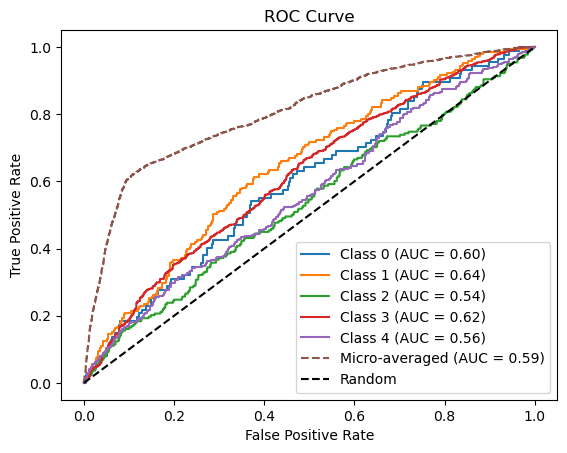

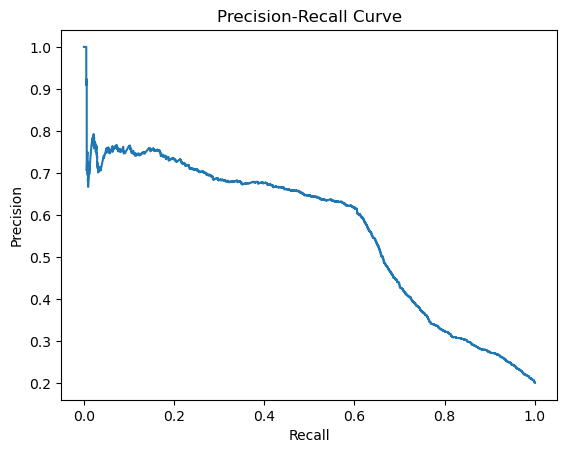

PR_AUC is  0.5626750207371015


'\nprecision, recall, fscore, support = precision_recall_fscore_support(true_labels, pred_labels)\n# Print the results for each class\nfor i in range(num_classes):\n    print(f"Class {i}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1-score={fscore[i]:.3f}")\n# Plot the precision-recall curve\nplt.plot(recall, precision)\nplt.xlabel(\'Recall\')\nplt.ylabel(\'Precision\')\nplt.title(\'Precision-Recall Curve for baseline resnet-18\')\nplt.show()\n\nauc_roc = roc_auc_score(true_labels, pred_labels, multi_class=\'ova\')\nprint(f"auc_roc: {auc_roc:.4f}")\n'

In [124]:


print(classification_report(true_labels, pred_labels))

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
print(f"Confusion matrix:\n{conf_matrix}")

# Compute probabilities for each class

probs_labels = np.array(probs_labels)

print("probs labels shape:", len(probs_labels))

# Compute ROC-AUC scores for each class
auc_scores = []
for i in range(num_classes):
    true_labels_i = (np.array(true_labels) == i).astype(int)
    probs_i = probs_labels[:, i]
    auc_i = roc_auc_score(true_labels_i, probs_i)
    auc_scores.append(auc_i)
    print(f"Class {i}: AUC = {auc_i:.3f}")

# Compute micro-averaged ROC-AUC score
auc_micro = roc_auc_score(np.eye(num_classes)[true_labels], probs_labels, multi_class="ovr")
print(f"Micro-averaged AUC = {auc_micro:.3f}")

# Plot ROC curves for each class
fpr = dict()
tpr = dict()
for i in range(num_classes):
    true_labels_i = (np.array(true_labels) == i).astype(int)
    probs_i = probs_labels[:, i]
    fpr[i], tpr[i], _ = roc_curve(true_labels_i, probs_i)
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {auc_scores[i]:.2f})")

# Plot micro-averaged ROC curve
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[true_labels].ravel(), probs_labels.ravel())
plt.plot(fpr_micro, tpr_micro, label=f"Micro-averaged (AUC = {auc_micro:.2f})", linestyle="--")

# Plot random classifier curve
plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#precision-recall
#first binarize the labels
bin_labels = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])
precision, recall, thresholds = precision_recall_curve(bin_labels.ravel(), probs_labels.ravel())
pr_auc = auc(recall, precision)
#precision, recall, thresholds = precision_recall_curve(true_labels, pred_labels)
plt.plot(recall, precision, label = {pr_auc})
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
print("PR_AUC is ", pr_auc)




'''
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label="class {} (AUC = {:.2f})".format(i, pr_auc[i]))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()
'''
'''
precision, recall, fscore, support = precision_recall_fscore_support(true_labels, pred_labels)
# Print the results for each class
for i in range(num_classes):
    print(f"Class {i}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1-score={fscore[i]:.3f}")
# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for baseline resnet-18')
plt.show()

auc_roc = roc_auc_score(true_labels, pred_labels, multi_class='ova')
print(f"auc_roc: {auc_roc:.4f}")
'''

In [31]:
model = VitClassifier(model_name="vit_base_patch16_224", n_classes=5, pretrained=True)
state_dict = torch.load(f"models/vit_23:29_epoch_2.pth")
model.load_state_dict(state_dict)

model.eval()

if torch.cuda.is_available(): model.cuda()
# Create empty lists for true labels and predicted labels
true_labels = []
pred_labels = []
probs_labels = []
# Iterate over test dataset and make predictions
with torch.no_grad():
    pbar = tqdm(enumerate(test_loader), total=len(test_loader))
    for step, (inputs, labels) in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        preds = F.softmax(outputs, dim=1).argmax(dim=1)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        probs_labels.extend(probs)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

100%|██████████| 122/122 [01:12<00:00,  1.68it/s]


              precision    recall  f1-score   support

           0       0.49      0.77      0.60        99
           1       0.73      0.78      0.76       181
           2       0.87      0.55      0.67       226
           3       0.90      0.99      0.94      1208
           4       0.85      0.48      0.62       232

    accuracy                           0.84      1946
   macro avg       0.77      0.71      0.72      1946
weighted avg       0.85      0.84      0.84      1946

Accuracy: 0.8448
Precision: 0.8536
Recall: 0.8448
F1 score: 0.8360
Confusion matrix:
[[  76   13    0    7    3]
 [  21  141    2   10    7]
 [   9   12  124   73    8]
 [   3    9    4 1191    1]
 [  45   17   13   45  112]]
probs labels shape: 1946
Class 0: AUC = 0.967
Class 1: AUC = 0.975
Class 2: AUC = 0.952
Class 3: AUC = 0.984
Class 4: AUC = 0.963
Micro-averaged AUC = 0.968


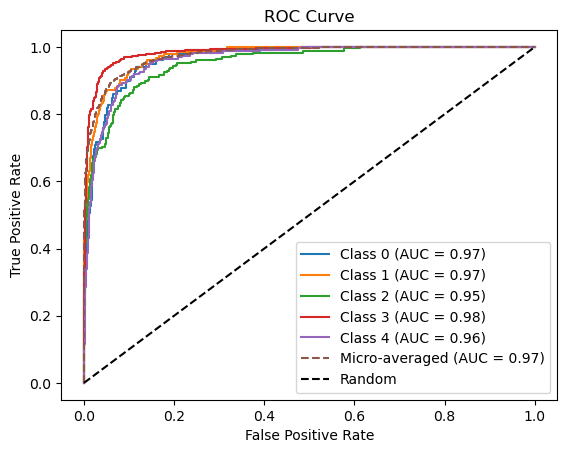

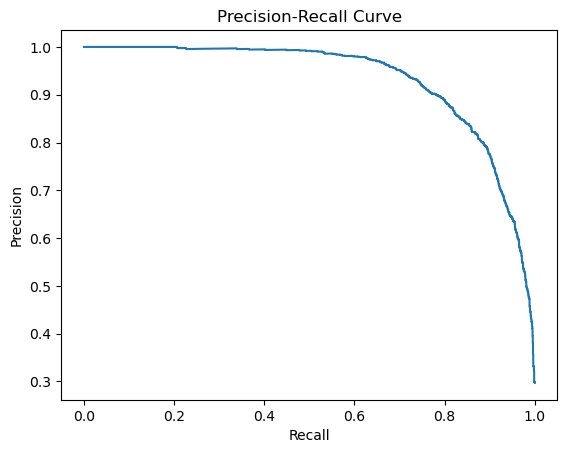

PR_AUC is  0.9309140802850708


In [33]:
print(classification_report(true_labels, pred_labels))

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')
num_classes = 5
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
print(f"Confusion matrix:\n{conf_matrix}")

# Compute probabilities for each class

probs_labels = np.array(probs_labels)

print("probs labels shape:", len(probs_labels))

# Compute ROC-AUC scores for each class
auc_scores = []
for i in range(num_classes):
    true_labels_i = (np.array(true_labels) == i).astype(int)
    probs_i = probs_labels[:, i]
    auc_i = roc_auc_score(true_labels_i, probs_i)
    auc_scores.append(auc_i)
    print(f"Class {i}: AUC = {auc_i:.3f}")

# Compute micro-averaged ROC-AUC score
auc_micro = roc_auc_score(np.eye(num_classes)[true_labels], probs_labels, multi_class="ovr")
print(f"Micro-averaged AUC = {auc_micro:.3f}")

# Plot ROC curves for each class
fpr = dict()
tpr = dict()
for i in range(num_classes):
    true_labels_i = (np.array(true_labels) == i).astype(int)
    probs_i = probs_labels[:, i]
    fpr[i], tpr[i], _ = roc_curve(true_labels_i, probs_i)
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {auc_scores[i]:.2f})")

# Plot micro-averaged ROC curve
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[true_labels].ravel(), probs_labels.ravel())
plt.plot(fpr_micro, tpr_micro, label=f"Micro-averaged (AUC = {auc_micro:.2f})", linestyle="--")

# Plot random classifier curve
plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#precision-recall
#first binarize the labels
bin_labels = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])
precision, recall, thresholds = precision_recall_curve(bin_labels.ravel(), probs_labels.ravel())
pr_auc = auc(recall, precision)
#precision, recall, thresholds = precision_recall_curve(true_labels, pred_labels)
plt.plot(recall, precision, label = {pr_auc})
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
print("PR_AUC is ", pr_auc)

## 3. DataShift Evaluation

### Evaluation on test set with diff transfrom 

In [102]:
transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

valid_dataset = CassavaDataset(train_data_path, s3_prefix, transform=transforms_valid)
_, valid_test_dataset = random_split(valid_dataset, [train_size, test_size])

# Load data
batch_size = 32
valid_test_loader = DataLoader(valid_test_dataset, batch_size=batch_size, shuffle=True)

In [119]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_curve
import torch.nn.functional as F
import torch
import torchvision.models as models
import torch.nn as nn

'''
state_dict = torch.load("models/resnet18-20:03.pth")
print(state_dict.keys())

model = models.resnet18()
print(model.state_dict().keys())
'''

resnet = models.resnet18(pretrained=False)
num_classes = 5
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, num_classes)

resnet.load_state_dict(torch.load("models/resnet18-20:03.pth"))
resnet.eval()

if torch.cuda.is_available(): resnet.cuda()
# Create empty lists for true labels and predicted labels
true_labels = []
pred_labels = []
probs_labels = []
# Iterate over test dataset and make predictions
with torch.no_grad():
    for inputs, labels in valid_test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = resnet(inputs)
        preds = F.softmax(outputs, dim=1).argmax(dim=1)
        probs = F.softmax(outputs, dim=1).cpu().numpy()
        probs_labels.extend(probs)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ec2-user/anaconda3/envs/pytorch_p39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


              precision    recall  f1-score   support

           0       0.56      0.80      0.66        85
           1       0.87      0.75      0.81       209
           2       0.81      0.70      0.75       226
           3       0.97      0.93      0.95      1192
           4       0.65      0.83      0.73       234

    accuracy                           0.87      1946
   macro avg       0.77      0.80      0.78      1946
weighted avg       0.88      0.87      0.87      1946

Accuracy: 0.8684
Precision: 0.8830
Recall: 0.8684
F1 score: 0.8723
Confusion matrix:
[[  68    2    1    1   13]
 [  17  157    1    7   27]
 [   7    5  159   23   32]
 [  12   10   27 1111   32]
 [  18    6    9    6  195]]
probs labels shape: 1946
Class 0: AUC = 0.979
Class 1: AUC = 0.979
Class 2: AUC = 0.958
Class 3: AUC = 0.984
Class 4: AUC = 0.967
Micro-averaged AUC = 0.973


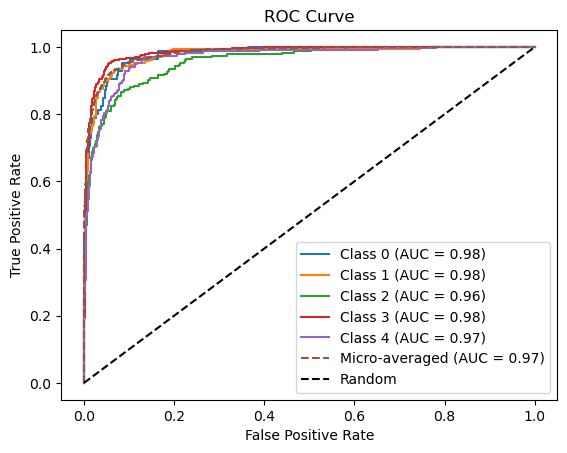

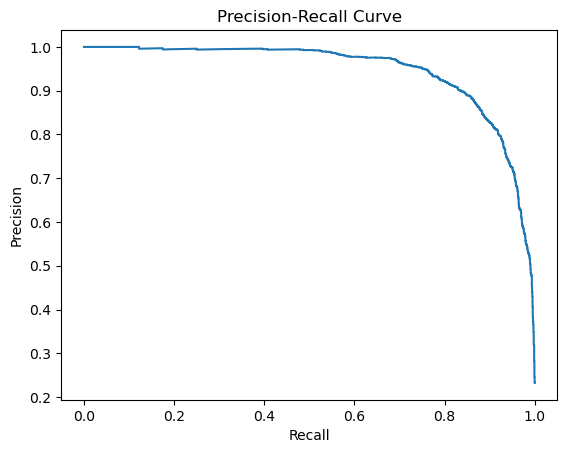

PR_AUC is  0.9450046210547643


'\nprecision, recall, fscore, support = precision_recall_fscore_support(true_labels, pred_labels)\n# Print the results for each class\nfor i in range(num_classes):\n    print(f"Class {i}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1-score={fscore[i]:.3f}")\n# Plot the precision-recall curve\nplt.plot(recall, precision)\nplt.xlabel(\'Recall\')\nplt.ylabel(\'Precision\')\nplt.title(\'Precision-Recall Curve for baseline resnet-18\')\nplt.show()\n\nauc_roc = roc_auc_score(true_labels, pred_labels, multi_class=\'ova\')\nprint(f"auc_roc: {auc_roc:.4f}")\n'

In [120]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

print(classification_report(true_labels, pred_labels))

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(true_labels, pred_labels)
precision = precision_score(true_labels, pred_labels, average='weighted')
recall = recall_score(true_labels, pred_labels, average='weighted')
f1 = f1_score(true_labels, pred_labels, average='weighted')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 score: {f1:.4f}")

# Calculate and print confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)
print(f"Confusion matrix:\n{conf_matrix}")

# Compute probabilities for each class
'''
moved above, this hasn't been deleted yet, del if above works
with torch.no_grad():
    probs = F.softmax(resnet(inputs), dim=1).cpu().numpy()
'''
probs_labels = np.array(probs_labels)

print("probs labels shape:", len(probs_labels))

# Compute ROC-AUC scores for each class
auc_scores = []
for i in range(num_classes):
    true_labels_i = (np.array(true_labels) == i).astype(int)
    probs_i = probs_labels[:, i]
    auc_i = roc_auc_score(true_labels_i, probs_i)
    auc_scores.append(auc_i)
    print(f"Class {i}: AUC = {auc_i:.3f}")

# Compute micro-averaged ROC-AUC score
auc_micro = roc_auc_score(np.eye(num_classes)[true_labels], probs_labels, multi_class="ovr")
print(f"Micro-averaged AUC = {auc_micro:.3f}")

# Plot ROC curves for each class
fpr = dict()
tpr = dict()
for i in range(num_classes):
    true_labels_i = (np.array(true_labels) == i).astype(int)
    probs_i = probs_labels[:, i]
    fpr[i], tpr[i], _ = roc_curve(true_labels_i, probs_i)
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {auc_scores[i]:.2f})")

# Plot micro-averaged ROC curve
fpr_micro, tpr_micro, _ = roc_curve(np.eye(num_classes)[true_labels].ravel(), probs_labels.ravel())
plt.plot(fpr_micro, tpr_micro, label=f"Micro-averaged (AUC = {auc_micro:.2f})", linestyle="--")

# Plot random classifier curve
plt.plot([0, 1], [0, 1], "k--", label="Random")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

#precision-recall
#first binarize the labels
bin_labels = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])
precision, recall, thresholds = precision_recall_curve(bin_labels.ravel(), probs_labels.ravel())
pr_auc = auc(recall, precision)
#precision, recall, thresholds = precision_recall_curve(true_labels, pred_labels)
plt.plot(recall, precision, label = {pr_auc})
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()
print("PR_AUC is ", pr_auc)




'''
for i in range(num_classes):
    plt.plot(recall[i], precision[i], label="class {} (AUC = {:.2f})".format(i, pr_auc[i]))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="lower left")
plt.show()
'''
'''
precision, recall, fscore, support = precision_recall_fscore_support(true_labels, pred_labels)
# Print the results for each class
for i in range(num_classes):
    print(f"Class {i}: Precision={precision[i]:.3f}, Recall={recall[i]:.3f}, F1-score={fscore[i]:.3f}")
# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for baseline resnet-18')
plt.show()

auc_roc = roc_auc_score(true_labels, pred_labels, multi_class='ova')
print(f"auc_roc: {auc_roc:.4f}")
'''